# try

#### 04/02
---
### experiments
|idx | size     |filtering |aug |epoch |complete | |
|:---:|:---:|:---:|:---:|:---:|:---:|:---|
|1   | 224x224  | x | default | 100 | v | |
|2   | 1280x720 | x | default | 100 | v | |
|3   | 224x224  | o | default | 100 | v | |
|4   | 224x224  | o | 0.0     | 32  | v |pateince=15에 의해 중단, overfitting|
|5   | 224x224  | o | < 0.1   | 100 | v |image domain aug라도 필요|
|6   | 1280x720 | o | default | 100 | v |성능 비교를 위한 추가학습|

#### parameter

| split | patience | seed | batch | workers |
|:---:|:---:|:---:|:---:|:---:|
| 7 : 1.5 : 1.5 | 15 | 42 | 16 | 4 | 

```
# hyperparameter
model.train(data = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/data_filtered224.yaml',
            name = 'train0405_224_with_filtering_aug_0_1',

            epochs = 100,
            patience = 15,
            imgsz = 640,
            seed = 42,
            #iou = 0.75, ####### iou 설정 (default: 0.7)
            batch = 16,
            workers = 4,

            # augmentation
            # hsv_h = 0.0, # default = 0.015
            hsv_s = 0.1, # default = 0.7
            hsv_v = 0.1, # default = 0.4
            #translate = 0.0, # default = 0.1
            scale = 0.1, # default = 0.5
            fliplr = 0.1, # default = 0.5
            mosaic = 0.1, # default = 1.0
            # auto_augment = '', # or None # default = randaugment
            erasing = 0.1, # default = 0.4
            crop_fraction = 0.1 # default = 1.0
```



#### result directory : ~/runs/detect/
||folder_name|size|filtering|aug|
|---|---|---|---|---|
|1. |train0403_size1280                   |: size 1280x720, |filtering X, |augmentation(image domain) - yolov8 default|
|2. |train0403_size224                    |: size 224x224,  |filtering X, |augmentation(image domain) - yolov8 default|
|3. |train0405_1280_with_filtering        |: size 1280x720, |filtering 5, |augmentation(image domain) - yolov8 default|
|4. |train0405_224_with_filtering         |: size 224x224,  |filtering 5, |augmentation(image domain) - yolov8 default|
|5. |train0405_224_with_filtering_aug_0_1 |: size 224x224,  |filtering 5, |augmentation(image domain) - yolov8 0.1 이하|
|6. |train0405_224_with_filtering_no_aug  |: size 224x224,  |filtering 5, |augmentation(image domain) - X|


In [1]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns

sns.set_style('darkgrid')

%matplotlib inline

In [2]:
current_directory = os.getcwd()
print(current_directory)

/home/sogaksa123/AIFFEL_THON/data/dataset6_fix_0408


In [3]:
l = os.listdir('/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/')
print(l[:10])
len(l)

['labels', 'Training', '.ipynb_checkpoints', 'test_0408.yaml', 'data_filtered224.yaml']


5

### directory 설정

In [6]:
# train for iou 0.5 

'''
params : 
    size = 224
    filter_num = 5
    y_axis : "same"
    
    epochs = 100,
    patience = 15,
    imgsz = 640,
    seed = 42,
    iou = 0.5, 
    batch = 16,
    workers = 4
'''

train_images = "/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/train/images"
train_labels = "/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/train/labels"

test_images = "/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images"
test_labels = "/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/labels"

val_images = "/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/val/images"
val_labels = "/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/val/labels"

In [7]:
print(len(os.listdir(train_images)))
print(len(os.listdir(train_labels)))
print(len(os.listdir(test_images)))
print(len(os.listdir(test_labels)))
print(len(os.listdir(val_images)))
print(len(os.listdir(val_labels)))

2084
2084
446
446
446
446


### training 전 데이터 확인(시각화)

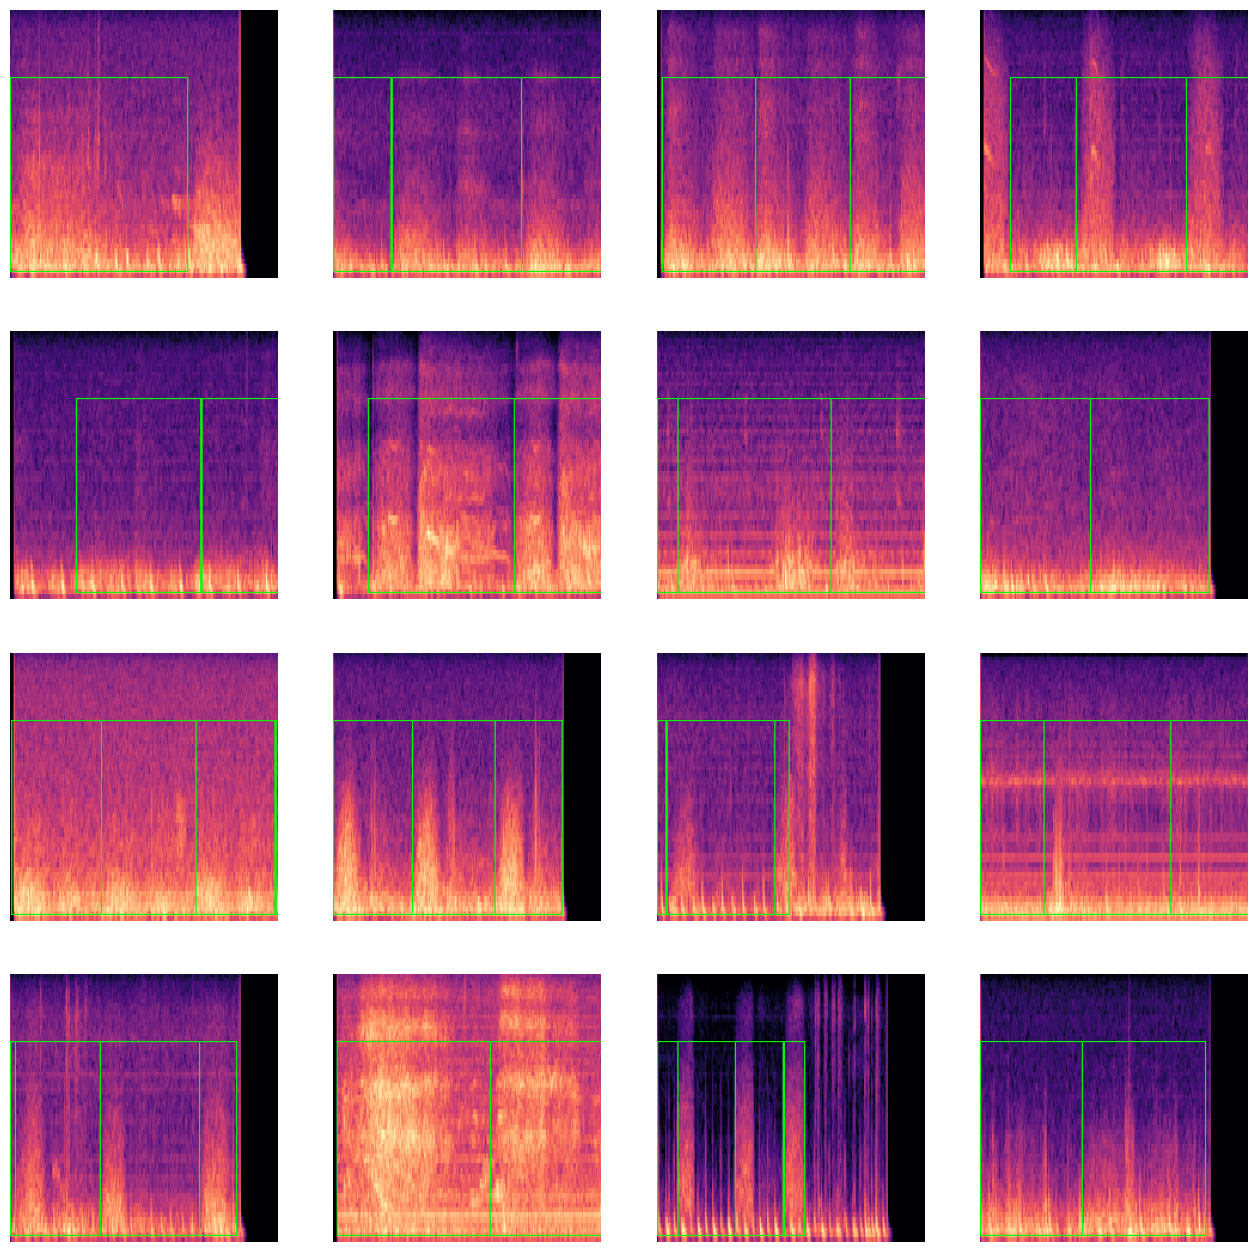

In [8]:
# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)
# random_images = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# fig, axs = plt.subplots(4, 3, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    # row = i // 3
    # col = i % 3
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [9]:
#Image Metadata
# AIFFEL_THON/data/dataset4_0331/with_normal_1280_720/png_files/101_1b1_Al_sc_Meditron_0.png
# Load an image using OpenCV
image = cv2.imread("/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/test/images/174_1p3_Pr_mc_AKGC417L_1.png")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 224x224 and 3 channels.


## Training
---
[[참고링크] YOLOv8 모델 설정 파라미터](https://docs.ultralytics.com/ko/modes/train/#resuming-interrupted-trainings)

- `imgsz`:	학습을 위한 목표 이미지 크기입니다. 모든 이미지는 모델에 입력되기 전에 이 크기로 조정됩니다. 모델 정확도와 계산 복잡도에 영향을 줍니다.


In [9]:
import torch
torch.cuda.empty_cache()

In [17]:
# #Model Training
# # Loading a pretrained model
# model = YOLO('yolov8x.pt')

# # Training the model
# model.train(data = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/data224.yaml',
#             name = 'train0403_size224',
#             epochs = 100,
#             patience = 15,
#             imgsz = 640,
#             seed = 42,
#             iou = 0.75,
#             batch = 16,
#             workers = 4)

New https://pypi.org/project/ultralytics/8.1.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22491MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/data224.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train0403_size224, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnost

train: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/train/labels.cache... 2084 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2084/2084 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]


Plotting labels to runs/detect/train0403_size224/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train0403_size224
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.2G      1.525      2.358      1.766         39        640: 100%|██████████| 131/131 [01:35<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]

                   all        446       1468     0.0179      0.124     0.0111    0.00342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.9G      1.323      2.165      1.567         32        640: 100%|██████████| 131/131 [01:33<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]

                   all        446       1468     0.0834      0.321     0.0839      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.9G      1.183      2.094      1.436         14        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]

                   all        446       1468      0.424      0.336      0.124     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.9G       1.08      2.038      1.358         26        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.472      0.415      0.195      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.9G      1.023      1.997      1.317         23        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.146      0.568      0.166     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.9G      0.978      1.965      1.275         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.175      0.486       0.18     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.9G     0.9326      1.902      1.237         20        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.163      0.561      0.196       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.9G     0.8953      1.864      1.222         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.182      0.588       0.24      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.9G     0.8771      1.847      1.201         32        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.208      0.575      0.229      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.9G     0.8557      1.821      1.193         28        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.217       0.55      0.248      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.9G     0.8451      1.802       1.19         26        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.207      0.501       0.24      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.9G     0.8216      1.766      1.176         28        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.214      0.543      0.258      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.9G     0.8207      1.761      1.168         22        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.239      0.541      0.255      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.9G     0.8206      1.745      1.167         38        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.241      0.592      0.264       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.9G     0.8029      1.718       1.16         29        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.251      0.627      0.283      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.9G     0.8015       1.71      1.156         29        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.202      0.587       0.26      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.9G     0.7698        1.7      1.145         30        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.237      0.516      0.233      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.9G      0.776      1.685      1.144         32        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.247      0.571      0.281      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.9G      0.763      1.668       1.14         20        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.234      0.607      0.285      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.9G       0.75      1.657      1.125         32        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.249      0.595      0.315      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.9G     0.7427      1.631      1.125         23        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.29        0.6      0.312      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.9G     0.7399      1.616      1.119         33        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.266      0.602      0.301       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.9G     0.7313      1.609      1.122         27        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.251      0.594      0.294      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.9G     0.7352      1.625      1.123         32        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.267      0.659      0.312      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.9G     0.7276      1.614      1.113         24        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.226      0.603      0.264      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.9G     0.7167      1.582      1.111         23        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.248      0.586      0.289      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.9G     0.7104      1.585      1.106         35        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.283      0.615      0.314      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.9G     0.7096      1.575      1.112         33        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.262      0.546      0.294      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.9G     0.7127       1.57      1.108         21        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.255      0.625      0.297       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.9G     0.7069      1.556      1.109         34        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.254      0.587      0.284      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.9G     0.6867      1.535      1.098         17        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.282       0.57      0.309      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.9G     0.6875      1.557      1.093         17        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.246       0.66      0.316      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.9G     0.6941      1.554      1.098         28        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.265      0.557      0.275      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.9G     0.6817      1.532      1.097         25        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.277      0.601      0.331      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.9G     0.6708      1.524      1.085         41        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.259      0.637      0.318      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.9G     0.6686      1.519      1.081         29        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.303      0.623      0.377      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.9G     0.6799      1.499      1.088         22        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.307      0.606      0.353      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.9G     0.6747      1.503      1.088         33        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.281       0.58      0.321      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.9G     0.6554      1.491      1.076         27        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.281      0.625      0.349      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.9G     0.6578      1.481      1.081         16        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.294      0.625       0.34      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.9G     0.6629      1.495      1.082         35        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.247      0.604      0.282      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.9G     0.6582      1.509      1.075         29        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.311      0.604      0.334      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.9G     0.6515      1.475      1.073         28        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.315      0.669      0.379      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.9G      0.646      1.443      1.063         33        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.305      0.645      0.361      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.9G     0.6523      1.433      1.076         18        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.302      0.598      0.357      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.9G      0.646      1.458      1.077         22        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.336      0.611      0.382      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.9G     0.6368      1.439      1.066         24        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.363      0.603      0.414      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.9G     0.6216      1.425      1.057         22        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.321      0.583      0.378      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.9G     0.6286      1.428      1.065         21        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.357      0.614      0.409      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.9G     0.6234      1.425      1.059         33        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.357      0.604      0.408      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.9G     0.6198      1.409      1.058         24        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.303       0.51       0.32      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.9G     0.6196      1.404      1.054         25        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.333      0.584      0.373      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.9G      0.622      1.411      1.058         23        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.372      0.628      0.448      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.9G      0.606      1.404      1.049         34        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.408      0.585      0.439      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.9G     0.6023      1.368      1.041         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.452      0.575      0.473      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.9G     0.6048      1.371      1.053         24        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.406      0.587      0.459      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      14.9G       0.61      1.396      1.053         29        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.394      0.593       0.44      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.9G     0.6022       1.36      1.045         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.392      0.596      0.443      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.9G     0.6079       1.35      1.046         27        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468       0.45      0.575      0.476      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      14.9G     0.5964      1.351      1.042         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.37      0.573      0.409      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.9G     0.6045      1.337      1.048         22        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.479       0.59      0.529      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      14.9G     0.5926      1.329      1.039         41        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.42      0.579      0.482      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      14.9G     0.5911      1.318      1.035         23        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.518      0.588      0.544      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.9G     0.5795      1.304      1.033         36        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.462      0.552       0.47      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      14.9G     0.5819      1.297      1.034         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.466      0.608      0.513      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.9G     0.5873      1.299      1.033         21        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.459      0.587      0.497      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      14.9G     0.5818      1.299      1.032         40        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.512      0.608      0.548      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.9G     0.5714      1.296      1.029         21        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.463      0.581      0.502      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      14.9G     0.5706       1.29      1.023         30        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.508      0.635      0.549      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      14.9G     0.5814      1.278       1.03         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.436       0.63      0.519      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      14.9G     0.5657      1.266      1.028         28        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.515      0.613      0.561      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      14.9G     0.5705      1.255      1.026         24        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.506      0.578      0.532      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      14.9G     0.5674      1.257      1.025         23        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.483      0.623      0.554      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      14.9G     0.5592      1.251      1.014         19        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.52      0.626      0.591      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      14.9G     0.5521      1.227      1.017         29        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.507      0.606       0.56      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      14.9G     0.5635      1.227      1.026         34        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.526      0.598      0.572      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      14.9G     0.5497      1.211      1.017         30        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.524      0.592      0.565      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      14.9G     0.5575      1.211      1.017         19        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.564      0.642      0.613      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      14.9G     0.5478      1.212      1.012         23        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.541      0.634      0.586      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      14.9G     0.5294      1.195      1.003         23        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.508       0.64       0.59      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      14.9G     0.5362      1.179      1.001         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.538      0.626      0.585      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      14.9G      0.532      1.176      1.003         28        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.548      0.641       0.61       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      14.9G     0.5311       1.16      1.001         21        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.525      0.591      0.567      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.9G     0.5242      1.157      1.004         29        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.596      0.618      0.619      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      14.9G     0.5132       1.13     0.9931         18        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.585      0.589      0.608      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      14.9G     0.5208      1.152     0.9969         33        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.583      0.595      0.612      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      14.9G     0.5186      1.136     0.9955         30        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.583      0.619      0.624      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.9G     0.5195      1.127     0.9991         17        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.554      0.654      0.615      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      14.9G     0.5199      1.118     0.9975         25        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.575      0.649      0.615      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.9G     0.5101       1.11     0.9939         31        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.563      0.644      0.624      0.534


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      14.9G      0.495      1.021     0.9701         14        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.575      0.636       0.62      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      14.9G     0.4863     0.9916      0.969         17        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.578       0.62      0.619       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      14.9G     0.4736     0.9634      0.955         10        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.59      0.636      0.628      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      14.9G     0.4763     0.9782     0.9652         13        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.595      0.643      0.637      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      14.9G     0.4688     0.9363     0.9578         13        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.604      0.615      0.636      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      14.9G     0.4653     0.9198     0.9501         12        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.599      0.628      0.651      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      14.9G     0.4604     0.8953     0.9514         15        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.62      0.621      0.652      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      14.9G     0.4561     0.9082     0.9571         10        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.62      0.598      0.646      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      14.9G     0.4446     0.8764     0.9396          9        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.63      0.618      0.665      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      14.9G     0.4361     0.8673     0.9323         12        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.64      0.604      0.664      0.565



100 epochs completed in 2.877 hours.
Optimizer stripped from runs/detect/train0403_size224/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train0403_size224/weights/best.pt, 136.7MB

Validating runs/detect/train0403_size224/weights/best.pt...
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22491MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]


                   all        446       1468       0.64      0.604      0.664      0.565
              crackles        446        429      0.601      0.562      0.618      0.533
               wheezes        446        318      0.668      0.575      0.675      0.581
                normal        446        721       0.65      0.674      0.699      0.581
Speed: 0.2ms preprocess, 13.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train0403_size224


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1b4e5dead0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [18]:
print("complete")

complete


In [20]:
# #Model Training
# # Loading a pretrained model
# model = YOLO('yolov8x.pt')

# # Training the model
# model.train(data = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_1280/data1280.yaml',
#             name = 'train0403_size1280',
#             epochs = 100,
#             patience = 15,
#             imgsz = 640,
#             seed = 42,
#             batch = 16,
#             workers = 4)

New https://pypi.org/project/ultralytics/8.1.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22491MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_1280/data1280.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train0403_size1280, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agn

train: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_1280/Training/data/train/labels... 2084 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2084/2084 [00:01<00:00, 1111.58it/s]

train: New cache created: /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_1280/Training/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_1280/Training/data/val/labels... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<00:00, 942.61it/s]

val: New cache created: /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/Yolo8_1280/Training/data/val/labels.cache


Plotting labels to runs/detect/train0403_size1280/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train0403_size1280
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       8.4G      1.298      2.281      1.579         41        640: 100%|██████████| 131/131 [01:33<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

                   all        446       1468      0.106      0.377     0.0875     0.0388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      16.4G       1.12       2.07       1.41         29        640: 100%|██████████| 131/131 [01:32<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

                   all        446       1468      0.397      0.183     0.0533     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      16.3G      1.049      1.986      1.355         26        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.159       0.54      0.196      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      16.4G     0.9818      1.921      1.313         37        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.168      0.503      0.186     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      16.4G     0.9243      1.848      1.271         23        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.183       0.54      0.212      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      16.4G     0.9031      1.833       1.26         27        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.173      0.553      0.212      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      16.5G     0.8685      1.783      1.233         26        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.219      0.405       0.27       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      16.4G     0.8655      1.761      1.229         30        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468       0.19      0.512      0.236       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      16.5G     0.4634     0.8882       0.99         16        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468      0.598      0.641       0.65      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      16.4G     0.4577     0.8937     0.9851         26        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

                   all        446       1468       0.61      0.654      0.656      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      16.4G     0.4415     0.8594     0.9703         23        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.588      0.648      0.642      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.44G     0.4432     0.8599     0.9715         33        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

                   all        446       1468      0.616      0.671      0.677      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      16.5G     0.4346     0.8618     0.9722         30        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.629      0.647      0.666      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      16.4G      0.432     0.8361     0.9676         33        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.644      0.647      0.665      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      16.4G     0.4328     0.8304     0.9694         28        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468      0.656      0.611      0.663      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      10.1G     0.4247     0.7985     0.9626         36        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

                   all        446       1468      0.597      0.664      0.661       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      16.4G     0.4164     0.7934     0.9591         33        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.595      0.659      0.668      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      16.4G     0.4189     0.7867     0.9634         29        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468      0.608      0.658      0.664      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      16.4G     0.4119      0.771     0.9579         17        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.641       0.64      0.676      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      16.5G     0.4053     0.7662     0.9536         20        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.645      0.644      0.678      0.579


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      16.2G     0.3841     0.6819     0.9318         14        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

                   all        446       1468      0.637       0.65      0.679      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      16.4G      0.361     0.6352     0.9105         17        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.613      0.649      0.667      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      16.4G     0.3484     0.6131     0.9039         10        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.626      0.652      0.679      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      16.5G     0.3497     0.6135     0.9087         13        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.645      0.642      0.679      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      16.5G     0.3362     0.5727     0.9003         13        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468      0.623      0.693      0.694      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      16.4G     0.3359       0.55      0.895         12        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.669      0.639       0.69      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      16.4G     0.3333     0.5398     0.8969         15        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.658       0.64      0.686      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      16.4G     0.3286     0.5472      0.897         10        640: 100%|██████████| 131/131 [01:32<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.662      0.646      0.689      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      16.5G     0.3221      0.519      0.886         10        640: 100%|██████████| 131/131 [01:31<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468       0.65      0.664      0.686      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      16.4G     0.3214     0.5079     0.8886         12        640: 100%|██████████| 131/131 [01:31<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468       0.65      0.657      0.683       0.58



100 epochs completed in 2.787 hours.
Optimizer stripped from runs/detect/train0403_size1280/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train0403_size1280/weights/best.pt, 136.7MB

Validating runs/detect/train0403_size1280/weights/best.pt...
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22491MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]


                   all        446       1468      0.627      0.688      0.695      0.594
              crackles        446        429      0.613      0.636      0.652      0.558
               wheezes        446        318      0.645      0.667      0.708      0.616
                normal        446        721      0.624      0.762      0.724      0.608
Speed: 0.1ms preprocess, 7.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train0403_size1280


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1a59c6eb90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [29]:
# #Model Training
# # Loading a pretrained model
# model = YOLO('yolov8x.pt')

# # Training the model
# model.train(data = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/data224_aug.yaml',
#             name = 'train0402_size224_with_aug',
#             epochs = 100,
#             patience = 15,
#             imgsz = 640,
#             seed = 42,
#             batch = 16,
#             workers = 4)

New https://pypi.org/project/ultralytics/8.1.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22491MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/data224_aug.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train0402_size224_with_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=

train: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/train_with_aug/labels... 2314 images, 464 backgrounds, 0 corrupt: 100%|██████████| 2778/2778 [00:02<00:00, 1329.10it/s]

train: New cache created: /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/train_with_aug/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]


Plotting labels to runs/detect/train0402_size224_with_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train0402_size224_with_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.8G      1.668      2.713      1.822         60        640: 100%|██████████| 174/174 [02:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]

                   all        446       1468     0.0816      0.465     0.0747     0.0301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.1G       1.37      2.333      1.643         42        640: 100%|██████████| 174/174 [02:25<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.123      0.315      0.107     0.0409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.1G      1.267      2.246      1.577         34        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]

                   all        446       1468      0.446      0.414       0.15     0.0687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.1G      1.193      2.185      1.543         33        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.488      0.392      0.193      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.3G      1.087      2.081      1.467         49        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.492      0.382       0.21      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.3G      1.074      2.066      1.455         47        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.487      0.385      0.206      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.3G       1.02      2.012      1.419         60        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468       0.16      0.565      0.194      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.3G      1.007       1.98      1.416         36        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.516      0.382      0.237      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.3G     0.9477      1.927      1.364         47        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.205      0.537      0.227      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.3G     0.9457       1.92      1.378         30        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.522      0.398      0.255      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.3G     0.9221       1.88      1.357         46        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.535        0.4      0.263      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.3G     0.9019      1.861      1.332         48        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.203      0.631      0.233      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.3G     0.8785      1.836      1.317         45        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.187      0.578      0.232       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.3G     0.8875      1.817      1.326         47        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468       0.21       0.54      0.247      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.3G     0.8591      1.807       1.31         36        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.263      0.568      0.273       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.3G     0.8461      1.798      1.308         30        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468       0.22      0.594      0.284      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.3G     0.8431      1.794      1.302         35        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.185      0.588      0.212      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.3G     0.8341      1.745      1.292         41        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.241      0.607      0.272      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.3G     0.8215       1.75      1.279         47        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.249      0.676      0.315      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.3G     0.8151       1.74      1.276         31        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.232      0.628      0.289      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.3G     0.7873      1.703      1.253         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.265      0.599      0.311      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.3G     0.7846        1.7      1.258         59        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.227      0.531      0.247      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.3G     0.7823      1.705      1.255         46        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.272      0.567      0.292      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.3G     0.7737      1.658      1.248         58        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.259      0.572      0.292      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.3G     0.7747      1.666      1.251         38        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.237      0.596       0.29      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.3G     0.7467      1.645      1.229         55        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.307      0.566      0.325       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.3G     0.7467      1.631      1.233         26        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.294      0.619      0.345      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.3G     0.7379      1.612      1.222         41        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.319      0.636      0.353       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.3G     0.7319      1.607      1.216         57        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.315      0.579      0.331      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.3G      0.715      1.578      1.202         45        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.338       0.58      0.349      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.3G     0.7404      1.618      1.225         51        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.313      0.587      0.347      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.3G     0.7147      1.581       1.21         53        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.267      0.632      0.315      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.3G     0.7128      1.556      1.212         41        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.349      0.613      0.375      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.3G     0.7118      1.583      1.207         35        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468       0.35       0.57      0.378      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.3G     0.6958      1.545      1.194         46        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.323      0.604       0.38      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.3G     0.6972      1.549      1.195         44        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.335      0.557      0.345      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.3G     0.6877      1.538      1.184         32        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468       0.37      0.567      0.392      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.3G     0.6748       1.51      1.174         37        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.388      0.602      0.416       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.3G     0.6646      1.506      1.169         27        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.389      0.634      0.428      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.3G     0.6678      1.511      1.176         29        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.342      0.584      0.402      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.3G      0.661      1.484       1.17         40        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.348      0.508      0.377      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.3G     0.6688      1.495      1.177         51        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.385      0.552      0.413      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.3G     0.6586      1.492      1.176         31        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.412      0.578      0.436      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.3G     0.6593      1.452      1.171         46        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.341      0.582      0.393      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.3G     0.6503      1.463       1.16         46        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.419      0.575      0.426      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.3G     0.6391      1.456      1.155         33        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.424      0.525      0.424      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.3G     0.6438      1.452       1.16         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.436      0.605      0.449      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.3G      0.647      1.465      1.163         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.443      0.562      0.458       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.3G     0.6362       1.45      1.149         39        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.407      0.553      0.428      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.3G     0.6332      1.437      1.153         43        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.441      0.553      0.464      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.3G     0.6334      1.442      1.157         41        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.383      0.565      0.422      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.3G     0.6272      1.424      1.144         34        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.449      0.556      0.449      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.3G      0.623      1.415      1.147         36        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.411      0.631      0.456      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.3G     0.6295      1.403      1.148         33        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.446      0.584       0.49      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.3G     0.6093      1.379      1.134         56        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.442      0.544      0.458       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.3G     0.6017       1.38      1.136         32        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.459      0.617      0.488      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.3G     0.6098      1.379      1.134         54        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.444      0.559      0.474       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.3G     0.6123      1.378      1.129         38        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.465      0.587      0.484       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.3G     0.5954      1.349      1.126         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.426      0.623      0.503      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.3G     0.6009      1.349      1.127         49        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.465      0.618      0.502      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.3G     0.5804      1.324      1.116         43        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468       0.45      0.597      0.503      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      13.3G     0.5873      1.348      1.118         47        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]

                   all        446       1468      0.472      0.569      0.484      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.3G     0.5777      1.322      1.113         34        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]

                   all        446       1468      0.461      0.601       0.51      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.3G     0.5851      1.317      1.117         37        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.471      0.615      0.511      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.3G      0.578      1.301      1.112         39        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.481      0.585      0.518      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.3G     0.5737      1.299      1.108         54        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.493      0.571      0.522       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.3G     0.5734      1.287      1.106         50        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.471       0.62      0.524      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      13.3G     0.5626      1.277      1.101         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.484      0.614      0.525      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.3G       0.57       1.29      1.111         38        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.479      0.611      0.525      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.3G      0.552      1.254      1.099         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.495      0.629      0.548      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      13.3G     0.5518      1.268      1.094         50        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.471      0.637      0.523      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.3G     0.5432      1.236      1.089         42        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.529      0.591      0.538      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.3G     0.5394      1.232      1.085         38        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.496      0.601      0.537      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.3G     0.5579      1.237      1.095         20        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.508      0.599      0.551      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      13.3G      0.538      1.223      1.085         53        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468       0.54      0.579      0.564       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.3G     0.5526      1.228      1.094         55        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.511      0.621      0.581      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.3G     0.5329      1.207      1.082         46        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468       0.53      0.603      0.561      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.3G      0.535      1.205      1.081         37        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.489      0.596      0.551       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.3G     0.5296      1.196      1.082         39        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.518      0.616      0.583      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      13.3G     0.5106      1.173      1.067         54        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.529      0.619      0.592      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.3G     0.5154      1.168       1.07         39        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.528      0.618      0.577      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.3G     0.5146      1.168      1.069         54        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.546       0.59      0.596      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      13.3G     0.5059      1.144      1.061         56        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.548      0.618      0.581      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.3G     0.5054      1.139      1.064         33        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.559      0.607      0.596      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.3G     0.4989      1.114      1.058         37        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.541      0.632      0.595      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.3G     0.5009      1.116      1.063         38        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]

                   all        446       1468      0.543      0.641      0.596        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.3G     0.4872       1.11      1.053         48        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.541      0.636      0.604      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.3G      0.496      1.112      1.062         45        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.545      0.651      0.604        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.3G     0.4908      1.101      1.058         42        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.538      0.655      0.608      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      13.3G     0.4835      1.076      1.051         49        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.559      0.619      0.605      0.498


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      13.3G     0.4854      1.047      1.063         23        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

                   all        446       1468      0.575      0.613      0.612      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      13.3G     0.4771      1.002      1.057         21        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468       0.58      0.597      0.609      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.3G     0.4845     0.9893      1.065         22        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.552      0.635      0.598      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      13.3G     0.4625     0.9647       1.05         22        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.546      0.646      0.607      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      13.3G     0.4592     0.9492       1.05         28        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.543      0.643      0.607      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.3G     0.4601     0.9463       1.05         20        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.557       0.63      0.609      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      13.3G     0.4576     0.9469      1.044         27        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

                   all        446       1468      0.578      0.624      0.628       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.3G     0.4429     0.9284      1.037         18        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]

                   all        446       1468      0.579      0.617      0.634      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      13.3G     0.4373     0.9082      1.033         17        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.572      0.645      0.626      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.3G      0.444     0.8927      1.033         18        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]

                   all        446       1468      0.579      0.636      0.628       0.52



100 epochs completed in 4.346 hours.
Optimizer stripped from runs/detect/train0402_size224_with_aug/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train0402_size224_with_aug/weights/best.pt, 136.7MB

Validating runs/detect/train0402_size224_with_aug/weights/best.pt...
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22491MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


                   all        446       1468       0.58      0.617      0.634      0.527
              crackles        446        429       0.55      0.515      0.578      0.491
               wheezes        446        318      0.634      0.593      0.686      0.571
                normal        446        721      0.556      0.743      0.637      0.519
Speed: 0.2ms preprocess, 13.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train0402_size224_with_aug


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe31eaa7cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
# #Model Training
# # Loading a pretrained model
# model = YOLO('yolov8x.pt')

# # Training the model
# model.train(data = '/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_1280/data1280_aug.yaml',
#             name = 'train0403_size1280_with_aug',
#             epochs = 100,
#             patience = 15,
#             imgsz = 640,
#             seed = 42,
#             batch = 16,
#             workers = 4)

New https://pypi.org/project/ultralytics/8.1.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22491MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_1280/data1280_aug.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train0403_size1280_with_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augme

train: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_1280/Training/data/train_with_aug/labels... 2340 images, 438 backgrounds, 0 corrupt: 100%|██████████| 2778/2778 [00:07<00:00, 362.14it/s]


train: New cache created: /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_1280/Training/data/train_with_aug/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset4_0331/model/Yolov8/dataset/Yolo8_1280/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]


Plotting labels to runs/detect/train0403_size1280_with_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train0403_size1280_with_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.6G      1.596      2.532      1.701         64        640: 100%|██████████| 174/174 [02:27<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

                   all        446       1468     0.0631      0.607     0.0618     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.1G      1.314      2.198       1.56         34        640: 100%|██████████| 174/174 [02:26<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.472      0.294      0.167      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.3G      1.266      2.115       1.53         59        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.134      0.594      0.166     0.0848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.3G      1.177      2.055      1.489         60        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.138      0.511      0.165     0.0771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.3G      1.079      1.983      1.438         41        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468      0.203      0.597      0.254      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.3G      1.054      1.937      1.422         49        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.179      0.586      0.216      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.3G      0.996      1.876      1.391         59        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468      0.208      0.544      0.218      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.3G     0.9563      1.857      1.377         37        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468      0.175      0.591      0.223      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.3G     0.9278      1.824      1.358         51        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.197      0.551      0.214      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.3G     0.9021      1.776      1.332         51        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468       0.24      0.584      0.287      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.3G     0.8868      1.767      1.326         50        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468      0.244      0.552      0.258       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.3G     0.8576       1.73       1.31         61        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.253      0.574      0.283      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.3G     0.8471       1.71      1.299         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

                   all        446       1468      0.258      0.609      0.292        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.3G     0.8325      1.679      1.283         41        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.285      0.573      0.307      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.3G     0.8104      1.681      1.277         73        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.80it/s]

                   all        446       1468      0.231      0.538      0.243      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.3G      0.808      1.666      1.275         58        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.264      0.615      0.331      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.3G     0.7984      1.651      1.273         41        640: 100%|██████████| 174/174 [02:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

                   all        446       1468      0.299      0.596       0.33      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.3G     0.7939      1.626      1.269         56        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.277      0.543      0.292      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.3G     0.7732      1.606      1.257         62        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.315       0.57       0.35      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.3G     0.7683      1.593      1.242         44        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.343      0.588      0.412      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.3G     0.7489      1.558      1.235         40        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.346      0.574      0.375      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.3G     0.7479      1.585      1.238         64        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468      0.296      0.533      0.314        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.3G     0.7342      1.549      1.232         62        640: 100%|██████████| 174/174 [02:24<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.391      0.543      0.417      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.3G     0.7156      1.536      1.217         57        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

                   all        446       1468       0.37      0.584      0.398      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.3G     0.7239      1.519      1.219         49        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468      0.373      0.555      0.373      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.3G     0.7083       1.51       1.21         49        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

                   all        446       1468      0.359      0.546      0.401      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.3G      0.717      1.508      1.214         79        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

                   all        446       1468      0.413      0.551      0.433      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.3G     0.7034      1.465      1.202         61        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

                   all        446       1468      0.426      0.587      0.456       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.3G      0.705      1.476      1.208         56        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        446       1468      0.387      0.552      0.411      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.3G     0.7015      1.464        1.2         67        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468      0.407      0.593      0.416      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.3G     0.6852      1.447      1.188         65        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

                   all        446       1468      0.382      0.568      0.398      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.3G     0.6916      1.451      1.198         56        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468      0.447      0.627      0.472      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.3G     0.6755      1.431      1.192         49        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.374      0.475      0.374      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.3G     0.6716      1.416      1.179         63        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

                   all        446       1468      0.452      0.581      0.488      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.3G     0.6657      1.395      1.175         61        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468      0.419      0.622      0.442      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.3G     0.6498      1.378      1.163         52        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.462      0.594      0.489      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.3G     0.6516      1.389      1.173         57        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]

                   all        446       1468      0.483      0.573      0.507      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.3G     0.6388      1.371      1.155         77        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

                   all        446       1468      0.501      0.604      0.509      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.3G     0.6383       1.35      1.156         45        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        446       1468      0.423      0.569       0.48       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.3G     0.6329      1.339      1.154         47        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]

                   all        446       1468       0.48      0.595      0.517      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.3G     0.6261      1.321      1.142         60        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

                   all        446       1468      0.466      0.544      0.464      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.3G      0.618      1.322      1.143         64        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

                   all        446       1468      0.468      0.597      0.505      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.3G     0.6124      1.313      1.139         53        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

                   all        446       1468      0.468      0.621      0.517      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.3G     0.6201      1.291       1.14         67        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

                   all        446       1468      0.456      0.558      0.487      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.3G     0.6014      1.301      1.128         38        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

                   all        446       1468       0.51      0.624      0.548      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.3G     0.6017      1.268      1.133         39        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        446       1468      0.498      0.594      0.529      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.3G     0.5948      1.245      1.122         46        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

                   all        446       1468      0.482      0.611      0.532      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.3G     0.5873      1.236      1.122         45        640: 100%|██████████| 174/174 [02:24<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

                   all        446       1468      0.488      0.587      0.516      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.3G     0.5942      1.225      1.126        104        640:  87%|████████▋ | 151/174 [02:06<00:20,  1.11it/s]

### 1) iou0.5, size=224, filtering=5, aug=default

In [4]:
#Model Training
# Loading a pretrained model
model = YOLO('yolov8x.pt')

# Training the model
model.train(data = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/data_filtered224.yaml',
            name = 'train0408_224_filter5_iou05',
            epochs = 100,
            patience = 15,
            imgsz = 640,
            seed = 42,
            iou = 0.5, ####### iou 설정 (default: 0.7?)
            batch = 16,
            workers = 4)

New https://pypi.org/project/ultralytics/8.1.45 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22478MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/data_filtered224.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train0408_224_filter5_iou05, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False,

train: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/train/labels.cache... 2084 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2084/2084 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/Training/data/val/labels.cache... 446 images, 0 backgrounds, 0 corrupt: 100%|██████████| 446/446 [00:00<?, ?it/s]


Plotting labels to runs/detect/train0408_224_filter5_iou05/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train0408_224_filter5_iou05
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      16.3G      1.463      2.324      1.718         39        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468     0.0827      0.121     0.0309     0.0095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      15.1G      1.252      2.115      1.492         32        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.036       0.18     0.0257    0.00647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100        15G      1.143      2.052        1.4         14        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.114      0.633      0.131     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.2G      1.043      1.997      1.329         26        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468     0.0625      0.388     0.0647     0.0218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.2G      1.002      1.936      1.305         23        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.164      0.637      0.172     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.2G     0.9594      1.912      1.274         31        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.201      0.568      0.213      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.2G     0.9143      1.858       1.23         20        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.166      0.574      0.194     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.2G     0.8781      1.834      1.228         31        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.174      0.661      0.217      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.2G     0.8795      1.833      1.217         32        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.228      0.615      0.258      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.2G     0.8526      1.802      1.201         28        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.235      0.643      0.261      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.2G      0.844      1.788      1.201         26        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.221      0.617      0.259      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.2G     0.8172      1.756      1.183         28        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468       0.21      0.538       0.25      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.2G     0.8189      1.747      1.183         22        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.227      0.597      0.256      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.2G     0.8124       1.74      1.176         38        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.263       0.64      0.275      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.2G     0.7883        1.7      1.168         29        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.262      0.617      0.287      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.2G     0.7773      1.685      1.153         29        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.226      0.687      0.269       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.2G     0.7617       1.68      1.154         30        640: 100%|██████████| 131/131 [03:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.236      0.661      0.264      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.2G     0.7774      1.669      1.151         32        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.235      0.632      0.277      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.2G     0.7537      1.658      1.143         20        640: 100%|██████████| 131/131 [03:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.06it/s]

                   all        446       1468      0.247      0.631      0.275      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.2G     0.7424      1.635      1.136         32        640: 100%|██████████| 131/131 [03:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.247      0.669      0.298      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.2G     0.7288      1.619       1.13         23        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468       0.28      0.624      0.301       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.2G     0.7392      1.617      1.134         33        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.239      0.645      0.296      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.2G     0.7265      1.607      1.123         27        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.266      0.645      0.313      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.2G     0.7341      1.616      1.129         32        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.257       0.67      0.304      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.2G     0.7239      1.606      1.121         24        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.258      0.645      0.289       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.2G     0.7108      1.579      1.114         23        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.263      0.649      0.307      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.2G     0.7023      1.575      1.109         35        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.281      0.676      0.319      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.2G      0.712      1.568      1.112         33        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.291      0.627      0.319      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.2G     0.7179      1.578      1.117         21        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.285      0.657      0.324      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.2G     0.7002      1.546      1.111         34        640: 100%|██████████| 131/131 [03:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.256      0.671      0.304      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.2G     0.6779      1.518      1.102         17        640: 100%|██████████| 131/131 [03:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.277      0.615      0.308      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.2G     0.6786      1.529      1.096         17        640: 100%|██████████| 131/131 [03:53<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.243       0.66       0.32      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.2G     0.6772      1.535      1.098         28        640: 100%|██████████| 131/131 [03:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.312      0.686      0.344      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.2G      0.671      1.497      1.096         25        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.01s/it]

                   all        446       1468      0.293       0.65      0.323      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.2G     0.6598      1.495      1.088         41        640: 100%|██████████| 131/131 [03:56<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.01it/s]

                   all        446       1468      0.309      0.674      0.357      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.2G     0.6548      1.475       1.08         29        640: 100%|██████████| 131/131 [03:56<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.01it/s]

                   all        446       1468      0.299        0.7      0.362      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.2G     0.6597      1.467      1.086         22        640: 100%|██████████| 131/131 [03:56<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.02s/it]

                   all        446       1468      0.317      0.657      0.333      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.2G     0.6579      1.468      1.083         33        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.328      0.656      0.362      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.3G     0.6297      1.451      1.069         27        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.316      0.708      0.372      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.2G     0.6465      1.452      1.076         16        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.315      0.701       0.38      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.2G     0.6476      1.446      1.082         35        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.278      0.623      0.327      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.2G      0.647      1.461      1.075         29        640: 100%|██████████| 131/131 [03:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.01s/it]

                   all        446       1468       0.32      0.714      0.384      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.2G     0.6438      1.443      1.076         28        640: 100%|██████████| 131/131 [03:55<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.02s/it]

                   all        446       1468      0.324      0.664      0.375      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.2G     0.6248      1.411      1.065         33        640: 100%|██████████| 131/131 [03:55<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.293      0.665      0.345      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.2G     0.6259      1.414      1.069         18        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.312      0.709      0.371      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.2G     0.6318      1.423      1.077         22        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.327      0.662      0.376      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.2G     0.6297      1.423       1.07         24        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.326      0.723      0.383      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.2G     0.6095      1.396       1.06         22        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.323      0.693      0.386      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.2G     0.6081      1.398       1.06         21        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.326      0.651      0.373      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.2G      0.608      1.399      1.058         33        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.325      0.697      0.392      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.2G     0.6163      1.376      1.062         24        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.338      0.672      0.392      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.2G     0.5977       1.38       1.05         25        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.05it/s]

                   all        446       1468      0.335      0.714      0.422      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.2G     0.6084      1.385      1.059         23        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.03s/it]

                   all        446       1468      0.336      0.663      0.408      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.2G     0.5916      1.377      1.048         34        640: 100%|██████████| 131/131 [03:55<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.02s/it]

                   all        446       1468       0.36      0.661      0.434      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.2G     0.5879      1.347      1.044         31        640: 100%|██████████| 131/131 [03:54<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.363      0.638      0.427      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.2G     0.5862      1.358       1.05         24        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.337      0.672      0.413      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      14.2G     0.5922      1.363      1.051         29        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.364       0.65      0.441      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.2G     0.5894      1.347      1.044         31        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.374      0.665      0.436       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.2G     0.5884      1.332      1.047         27        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.383      0.606      0.419      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      14.2G     0.5722      1.338      1.042         31        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.363      0.695      0.451      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.2G     0.5916      1.332      1.054         22        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.393      0.641      0.444      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      14.2G     0.5759      1.318      1.041         41        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.402      0.665      0.476      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      14.3G      0.569      1.299      1.037         23        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.395      0.663      0.482      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.2G       0.56       1.29      1.033         36        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.443      0.641       0.49      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      14.2G      0.562      1.285      1.032         31        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.409      0.653      0.495      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.2G     0.5781      1.292      1.037         21        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.447      0.607      0.504      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      14.2G     0.5675      1.292      1.033         40        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.437      0.696      0.524      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.2G     0.5599       1.29       1.03         21        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.472      0.652      0.544       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      14.2G      0.559      1.283      1.026         30        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.483      0.626      0.543      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      14.3G     0.5647      1.262       1.03         31        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.477      0.633      0.542      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      14.2G     0.5589       1.26      1.027         28        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468       0.51      0.613      0.544      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      14.2G     0.5585      1.256      1.027         24        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.497      0.641      0.556      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      14.2G     0.5522      1.252      1.023         23        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.463      0.694      0.555      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      14.2G     0.5448      1.242      1.018         19        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.514      0.619      0.567      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      14.2G     0.5407      1.218      1.016         29        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.526      0.612      0.581      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      14.2G     0.5465      1.225      1.024         34        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.464       0.63      0.554      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      14.2G     0.5356      1.217      1.017         30        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468       0.52      0.626      0.596      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      14.2G     0.5502      1.205       1.02         19        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.505      0.676      0.594      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      14.2G     0.5363      1.203      1.014         23        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.505      0.647      0.586      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      14.2G     0.5267      1.193      1.011         23        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.559      0.633      0.617      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      14.2G     0.5239      1.176      1.004         31        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.556      0.656      0.619      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      14.2G     0.5243      1.178      1.011         28        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.529       0.61      0.611      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      14.2G     0.5222      1.162      1.006         21        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.554      0.617      0.607      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.2G     0.5164      1.159       1.01         29        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.583      0.628      0.626      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      14.2G     0.5095      1.133      1.001         18        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.566      0.646       0.63      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      14.2G     0.5137      1.145      1.002         33        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.548      0.668      0.629       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      14.2G     0.5088      1.136      0.998         30        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.616      0.629      0.634      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.2G     0.5098       1.13      1.002         17        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.592      0.635      0.623      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      14.2G     0.5124      1.129      1.003         25        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.632      0.606      0.636      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.3G     0.5024      1.119     0.9987         31        640: 100%|██████████| 131/131 [03:52<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.571      0.643      0.642      0.535


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      14.2G     0.4927      1.024     0.9723         14        640: 100%|██████████| 131/131 [04:00<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]

                   all        446       1468      0.588      0.669      0.652       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      14.2G     0.4798     0.9999     0.9672         17        640: 100%|██████████| 131/131 [04:58<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.568      0.653      0.638      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      14.2G     0.4712      0.969     0.9575         10        640: 100%|██████████| 131/131 [05:08<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:25<00:00,  1.82s/it]

                   all        446       1468      0.612      0.616      0.642      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      14.2G     0.4761     0.9815     0.9699         13        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.614      0.622       0.64      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      14.2G     0.4614     0.9423     0.9581         13        640: 100%|██████████| 131/131 [05:08<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.614      0.666      0.659      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      14.2G     0.4592     0.9297     0.9541         12        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.599      0.678       0.66      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      14.2G     0.4583     0.9201     0.9543         15        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.08it/s]

                   all        446       1468      0.573      0.692      0.659      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      14.3G     0.4544     0.9187     0.9606         10        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]

                   all        446       1468      0.582      0.689       0.66      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      14.2G     0.4387     0.8934     0.9392          9        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.606      0.674      0.664      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      14.2G     0.4401     0.8842      0.938         12        640: 100%|██████████| 131/131 [03:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]

                   all        446       1468      0.614      0.665      0.669       0.56



100 epochs completed in 7.022 hours.
Optimizer stripped from runs/detect/train0408_224_filter5_iou05/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train0408_224_filter5_iou05/weights/best.pt, 136.7MB

Validating runs/detect/train0408_224_filter5_iou05/weights/best.pt...
Ultralytics YOLOv8.1.40 🚀 Python-3.10.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA L4, 22478MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.04s/it]


                   all        446       1468      0.614      0.665      0.669       0.56
              crackles        446        429       0.53      0.685      0.642      0.543
               wheezes        446        318      0.654      0.604      0.677      0.575
                normal        446        721      0.657      0.706      0.686      0.562
Speed: 0.7ms preprocess, 26.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train0408_224_filter5_iou05


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff8b9ad93f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [5]:
print("Done")

Done


In [ ]:
# augmentation
'''
        type    defualt 범위
hsv_h	float	0.015	0.0 - 1.0	이미지의 색조를 컬러환의 일부분으로 조정하여 색상 가변성을 도입합니다. 다양한 조명 조건에서 모델을 일반화하는 데 도움이 됩니다.
hsv_s	float	0.7	    0.0 - 1.0	이미지의 채도를 일부 변경하여 색상의 강도에 영향을 줍니다. 다양한 환경 조건을 시뮬레이션하는 데 유용합니다.
hsv_v	float	0.4	    0.0 - 1.0	이미지의 값(밝기)을 일부 수정하여 다양한 조명 조건에서 모델이 잘 작동하도록 돕습니다.
degrees	float	0.0	    -180 - +180	지정된 각도 범위 내에서 이미지를 임의로 회전하여 다양한 방향에서 물체를 인식하는 모델의 능력을 향상시킵니다.
translate float 0.1	    0.0 - 1.0	이미지 크기를 가로 및 세로로 변환하여 부분적으로 보이는 물체를 감지하는 학습을 돕습니다.
scale	float	0.5	    >=0.0	    게인 계수에 따라 이미지의 크기를 조정하여 카메라에서 다양한 거리에 있는 물체를 시뮬레이션합니다.
shear	float	0.0	    -180 - +180	이미지를 지정된 각도만큼 잘라내어 물체를 다른 각도에서 보는 효과를 모방합니다.
perspective	float 0.0	0.0 - 0.001	이미지에 무작위 원근 변환을 적용하여 3D 공간에서 물체를 이해하는 모델의 능력을 향상시킵니다.
flipud	float	0.0	    0.0 - 1.0	지정된 확률로 이미지를 거꾸로 뒤집어 오브젝트의 특성에 영향을 주지 않고 데이터 가변성을 높입니다.
fliplr	float	0.5	    0.0 - 1.0	지정된 확률로 이미지를 왼쪽에서 오른쪽으로 뒤집어 대칭 개체를 학습하고 데이터 세트의 다양성을 높이는 데 유용합니다.
bgr	float	0.0	        0.0 - 1.0	지정된 확률로 이미지 채널을 RGB에서 BGR로 전환하여 잘못된 채널 순서에 대한 견고성을 높이는 데 유용합니다.
mosaic	float	1.0	    0.0 - 1.0	4개의 훈련 이미지를 하나로 결합하여 다양한 장면 구성과 물체 상호 작용을 시뮬레이션합니다. 복잡한 장면 이해에 매우 효과적입니다.
mixup	float	0.0	    0.0 - 1.0	두 이미지와 해당 레이블을 혼합하여 합성 이미지를 만듭니다. 레이블 노이즈와 시각적 가변성을 도입하여 모델의 일반화 능력을 향상시킵니다.
copy_paste	float  0.0	0.0 - 1.0	한 이미지에서 오브젝트를 복사하여 다른 이미지에 붙여넣는 기능으로 오브젝트 인스턴스를 늘리고 오브젝트 오클루전을 학습하는 데 유용합니다.
auto_augment strㅠ randaugment	-	미리 정의된 증강 정책을 자동으로 적용합니다(randaugment, autoaugment, augmix), 시각적 기능을 다양화하여 분류 작업에 최적화합니다.
erasing	float	0.4	    0.0 - 0.9	분류 훈련 중에 이미지의 일부를 임의로 지워 모델이 덜 분명한 특징에 집중하여 인식하도록 유도합니다.
crop_fraction float 1.0	0.1 - 1.0	분류 이미지를 일부 크기로 잘라내어 중심 특징을 강조하고 물체 크기에 맞게 조정하여 배경의 산만함을 줄입니다.
'''

### 2) nmels 64 -> 128, iou0.7, size=224, filtering=5, aug=default

In [ ]:
#Model Training
# Loading a pretrained model
model = YOLO('yolov8x.pt')

# Training the model
model.train(data = '/home/sogaksa123/AIFFEL_THON/data/dataset5_0403/model/Yolov8/dataset/filtered_224/data_filtered224.yaml',
            name = 'train0408_224_filter5_iou05',
            epochs = 100,
            patience = 15,
            imgsz = 640,
            seed = 42,
            iou = 0.5, ####### iou 설정 (default: 0.7?)
            batch = 16,
            workers = 4)